# Test data loading from different sources

- ARC-AGI
- ARC-AGI-2
- SRaven
- BBH

In [76]:
import os
import sys
import json
import jax
import jax.numpy as jnp
from einops import rearrange
import matplotlib.pyplot as plt

# make SRaven datasets
sys.path.append(os.path.abspath('..'))
from algorithms.hyla.hyla.data.raven import create_raven_datasets

In [11]:
# Test SRaven datasets

num_features = 8
feature_maxval = 64
grid_size = 3
permute_features = True

with jax.disable_jit(False):
    (ds_train, ds_eval, ds_callback), _ = create_raven_datasets(
        batch_size := 128,
        seq_len := ((9 - 1) * num_features) + num_features,
        num_train=1280, # 128000
        num_test=128,
        num_ood=128,
        num_features=num_features,
        feature_maxval=feature_maxval,
        grid_size=grid_size,
        permute_features=permute_features,
        frac_ood=0.25,
        seed=0,
    )

In [ ]:
## notes to self
## from --> Experiment: for step, batch in enumerate(iter(self.train_loader)):
## from --> Experiment:



n_batches = 4
batches = []
di_train = iter(ds_train)
for n, b in zip(range(n_batches), ds_train):
    batches.append(b)

In [ ]:
# examine some batches
# raven batches are shape (examples, num_features * 9, feature_maxval)
bx = batches[0].x
by = batches[0].y
print(bx.shape)
print(by.shape)

(128, 72, 64)
(128, 8)


In [99]:
# examine single example
ex = bx[0]
ex = rearrange(ex, '(a b) c -> a b c', a=9, b=8)
# verify one-hot encoding
jnp.unique(ex, return_counts=True)

(Array([0., 1.], dtype=float32), Array([4544,   64], dtype=int32))

In [100]:
ex = ex.argmax(axis=-1)
ex.shape

(9, 8)

In [103]:
data = ex

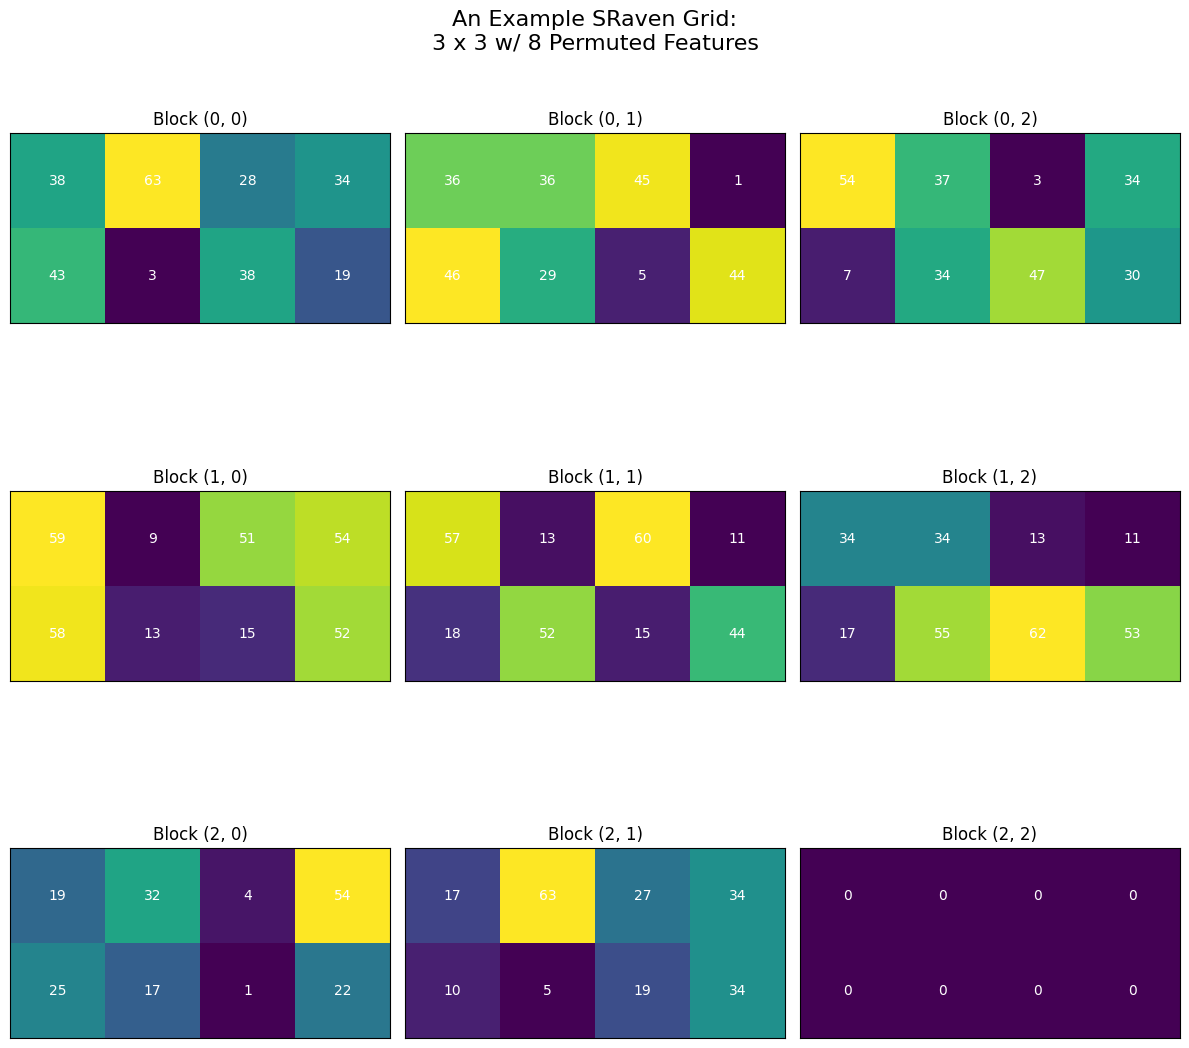

In [75]:
sraven_title = 'An Example SRaven Grid:\n3 x 3 w/ 8 Permuted Features'
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
cmap = plt.cm.viridis

# Loop through the 9 blocks (3×3 grid)
for block_idx in range(9):
    # Calculate row and column in the original array
    block_row = block_idx // 3
    block_col = block_idx % 3
    
    # Extract the corresponding 2×4 sub-array
    # Each block corresponds to one row of the original array
    block_data = data[block_idx].reshape(2, 4)
    
    # Plot this block in its corresponding axis
    im = axes[block_idx].imshow(block_data, cmap=cmap)
    
    # Add text annotations with values
    for i in range(2):
        for j in range(4):
            axes[block_idx].text(j, i, f'{int(block_data[i, j])}', 
                              ha='center', va='center', color='white')
    
    # Add titles to each block
    axes[block_idx].set_title(f'Block ({block_row}, {block_col})')
    
    # Remove ticks for cleaner appearance
    axes[block_idx].set_xticks([])
    axes[block_idx].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{sraven_title}', fontsize=16, y=0.98)
plt.show()

# Load some ARC data -- ensure consistent formatting

In [77]:
# Opening and loading JSON
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Saving JSON
def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)  # indent for pretty printing

In [86]:
# Note: training data visualized here
dataset_name = 'training'

filepath = f'../data/ARC-AGI-2/data/{dataset_name}/'
filenames = os.listdir(filepath)
print(f'ARC-AGI-2 {dataset_name} files:')
print('----------------------')
print('\n'.join(filenames[:10]))
print('...')

ARC-AGI-2 training files:
----------------------
a85d4709.json
c8cbb738.json
8e1813be.json
a699fb00.json
20fb2937.json
5c2c9af4.json
f0afb749.json
44f52bb0.json
94414823.json
23581191.json
...


In [145]:
# FILE FORMAT (one .json file per task):
## -----------------------------
# TASK: { [ { [[]] } ] }
# - 'train': key
# -- examples: [{ [[]] }]
# --- 'input': key
# ---- int[[]]
# --- 'output': key
# ---- int[[]]
# - 'test': key
# --- ibid. ...

index = 0
data = load_json(os.path.join(filepath, filenames[index]))
print(f'Filename:` {filenames[index]}')

Filename:` a85d4709.json


In [146]:
inputs = [data['train'][i]['input'] for i in range(len(data['train']))]
outputs = [data['train'][i]['output'] for i in range(len(data['train']))]
inputs, outputs

([[[5, 0, 0], [0, 5, 0], [5, 0, 0]],
  [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
  [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
  [[0, 0, 5], [0, 5, 0], [5, 0, 0]]],
 [[[2, 2, 2], [4, 4, 4], [2, 2, 2]],
  [[3, 3, 3], [3, 3, 3], [3, 3, 3]],
  [[4, 4, 4], [3, 3, 3], [4, 4, 4]],
  [[3, 3, 3], [4, 4, 4], [2, 2, 2]]])

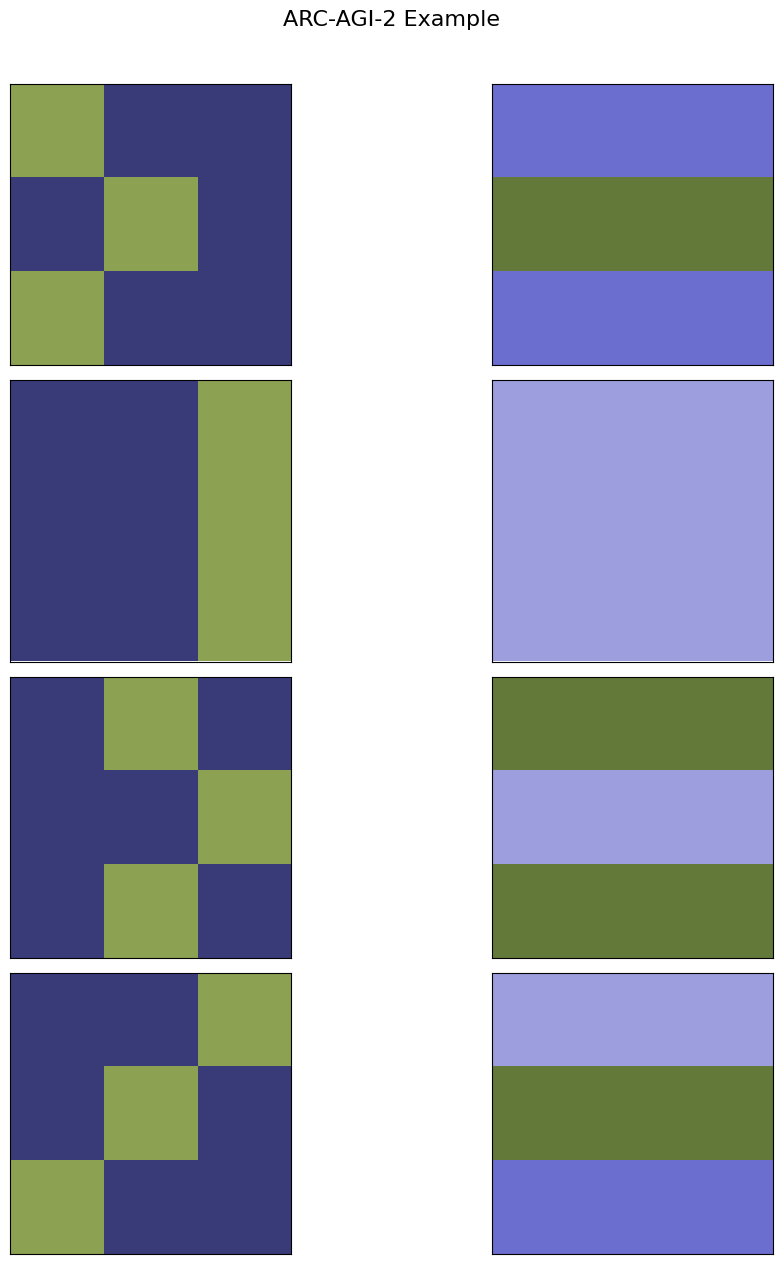

In [147]:
arc2_title = 'ARC-AGI-2 Example'

# global values
vmin = 0
vmax = 20

n_examples = len(data['train'])
fig, axes = plt.subplots(n_examples, 2, figsize=(12, 12))
cmap = plt.cm.tab20b

for r in range(n_examples):
    for c, label in enumerate(['input', 'output']):
        im = axes[r][c].imshow(data['train'][r][label], cmap=cmap, vmin=vmin, vmax=vmax)    
        # Remove ticks for cleaner appearance
        axes[r][c].set_xticks([])
        axes[r][c].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{arc2_title}', fontsize=16, y=1.05)
plt.show()

# Data Augmentation Primitives + Pretraining